## El Niño and seasonal sea ice loss in the Arctic and Antarctic

### Setup

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import os
import cftime
import nc_time_axis
from scipy.signal import detrend
from scipy import stats
from scipy import signal
import pandas as pd

In [2]:
# Helper functions
import os
import pooch
import tempfile

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/projects/SeaIce"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

## Accessing the data

### Sea ice data

In [3]:
# Code to retrieve and load the data if download from google cloud storage fails

link_id = 'bnjvp' # historical
#link_id = '4uytf' # ssp126
#link_id = '89tp2' # ssp245
#link_id = '' # ssp585

CMIP6_url = f"https://osf.io/download/{link_id}/"

siconca_fname = 'CMIP_NCAR_CESM2-WACCM_historical_r1i1p1f1_SImon_siconca_gn.nc'
#siconca_fname = 'CMIP_NCAR_CESM2-WACCM_ssp126_r1i1p1f1_SImon_siconca_gn.nc'
#siconca_fname = 'CMIP_NCAR_CESM2-WACCM_ssp245_r1i1p1f1_SImon_siconca_gn.nc'
#siconca_fname = 'CMIP_NCAR_CESM2-WACCM_ssp585_r1i1p1f1_SImon_siconca_gn.nc'
SI_ds_unmatched = xr.open_dataset(pooch_load(CMIP6_url, siconca_fname))

# Code to retrieve and load the data if download from google cloud storage fails

link_id = 'hgju4'
CMIP6_url = f"https://osf.io/download/{link_id}/"

metric_fname = 'CMIP_NCAR_CESM2-WACCM_historical_r1i1p1f1_fx_areacella_gn.nc'
SI_ds_metric = xr.open_dataset(pooch_load(CMIP6_url, metric_fname))

SHA256 hash of downloaded file: 227d103e483532f5f9ff8c076198be88cb4ade36083a7e9fec9fec39c61dfec8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 84085fd73d372f311979fd908cf3e08f625e35c3c459b2d9c2f0ff15bf9e935e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [4]:
SI_ds = xr.merge([SI_ds_unmatched, SI_ds_metric], compat='override')
SI_ds

<xarray.Dataset> Size: 441MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * x               (x) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
    time_bounds     (time, nbnd) object 32kB ...
    lat_bounds      (y, nbnd, x) float64 885kB ...
    lon_bounds      (x, nbnd, y) float64 885kB ...
  * nbnd            (nbnd) int64 16B 0 1
    lon             (x, y) float64 442kB ...
    lat             (x, y) float64 442kB ...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Data variables:
    siconca         (member_id, dcpp_init_year, time, y, x) float32 438MB ...
    areacella       (member_id, dcpp_init_year, y, x) float32 221kB ...
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            20075.0
    case_id:                          4
    ...                               ...
    intake_esm_attrs:variable_id:     siconca
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/...
    intake_esm_attrs:version:         20190507
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2-WACCM.historical.r1i1p1...

### ENSO data

In [5]:
# download the monthly sea surface temperature data from NOAA Physical System
# Laboratory. The data is processed using the OISST SST Climate Data Records
# from the NOAA CDR program.
# the data downloading may take 2-3 minutes to complete.
# filename=sst.mon.mean.nc
url_sst = "https://osf.io/6pgc2/download/"
filename = "sst.mon.mean.nc"

# we divide the data into small chunks to allow for easier memory manangement. this is all done automatically, no need for you to do anything
ds = xr.open_dataset(
pooch_load(filelocation=url_sst, filename=filename),
chunks={"time": 25, "latitude": 200, "longitude": 200},
)
ds

SHA256 hash of downloaded file: 577705b952b71abf66baf8710c38baaa87f00922b3f6a80109fdecb62b3e27c8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 2GB
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 2GB dask.array<chunksize=(25, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

### Preparing the data

In [6]:
# Slicing SST data in the Nino 3.4 region and for the time period
ds_ENSO=ds.sel(time= slice('1981-09-01','2014-12-31'), lat=slice(-5, 5), lon=slice(190, 240))

# Slicing SI data for the time period
SI_ds = SI_ds.sel(time= slice('1981-09-01','2014-12-31'))

### SIE (Sea Ice Extent) Calculation

In [7]:
# Selecting data above treshold
SIE = SI_ds.where(SI_ds.siconca > 15)

# Slicing for the arctic and antarctic
SIE_arctic = SIE.sel(y= slice(55,90))
SIE_antarctic = SIE.sel(y = slice(-90,-55))

## Calculating the total extent for each region
SIE_glob = SIE.areacella.sum(dim = ['x','y'])
SIE_arctic = SIE_arctic.areacella.sum(dim = ['x','y'])
SIE_antarctic = SIE_antarctic.areacella.sum(dim = ['x','y'])

### Anomaly Calculation

In [8]:
# Calculating climatologies
ENSO_clim = ds_ENSO.groupby('time.month').mean(dim = 'time')

SIE_glob_clim = SIE_glob.groupby('time.month').mean(dim = 'time')
SIE_arctic_clim = SIE_arctic.groupby('time.month').mean(dim = 'time')
SIE_antarctic_clim = SIE_antarctic.groupby('time.month').mean(dim = 'time')

In [9]:
# Anomaly Calculation
ENSO_anom = ds_ENSO.groupby('time.month') - ENSO_clim

SIE_glob_anom = SIE_glob.groupby('time.month') - SIE_glob_clim
SIE_arctic_anom = SIE_arctic.groupby('time.month') - SIE_arctic_clim
SIE_antarctic_anom = SIE_antarctic.groupby('time.month') - SIE_antarctic_clim

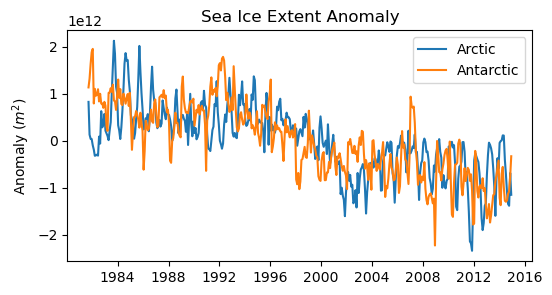

In [51]:
# sets figure size
plt.figure(figsize=(6,3))

# plot variables
plt.plot(SIE_arctic_anom.time, SIE_arctic_anom.squeeze(), label='Arctic')
plt.plot(SIE_antarctic_anom.time, SIE_antarctic_anom.squeeze(), label='Antarctic')

# sets labels and title
plt.ylabel('Anomaly $(m^2)$')
plt.title('Sea Ice Extent Anomaly')
plt.legend()

# saves image
plt.savefig('plot_art_ant.png', bbox_inches='tight')

In [10]:
ONI = ENSO_anom.sst.mean(dim=['lat','lon'])
nino1 = ONI.sel(time = slice('1996','2000')).where(ONI >= 0.5)
nino1

<xarray.DataArray 'sst' (time: 60)> Size: 240B
dask.array<where, shape=(60,), dtype=float32, chunksize=(25,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 480B 1996-01-01 1996-02-01 ... 2000-12-01
    month    (time) int64 480B 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [11]:
# Converting time data
def cftime_to_datetime64(cftime_dates): 
    return np.array([np.datetime64(date.strftime('%Y-%m-%d')) for date in cftime_dates]) 

new_time = cftime_to_datetime64(SIE_arctic_anom.coords['time'].values)
SIE_arctic_anom.coords['time'] = ('time', new_time)

/tmp/ipykernel_506/1672965810.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  SIE_arctic_anom.coords['time'] = ('time', new_time)


In [12]:
new_time = cftime_to_datetime64(SIE_antarctic_anom.coords['time'].values)
SIE_antarctic_anom.coords['time'] = ('time', new_time)

/tmp/ipykernel_506/2609032647.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  SIE_antarctic_anom.coords['time'] = ('time', new_time)


In [13]:
## Normalizing SIE anomaly
SIE_art_n = SIE_arctic_anom/1e12
SIE_ant_n = SIE_antarctic_anom/1e12

In [14]:
## Final variables and objects

#Global sst anomaly mean
oni = ENSO_anom.sst.mean(dim=['lat','lon'])

## removing singles value dimensions
SIE_art = SIE_art_n.squeeze()
SIE_ant = SIE_ant_n.squeeze()

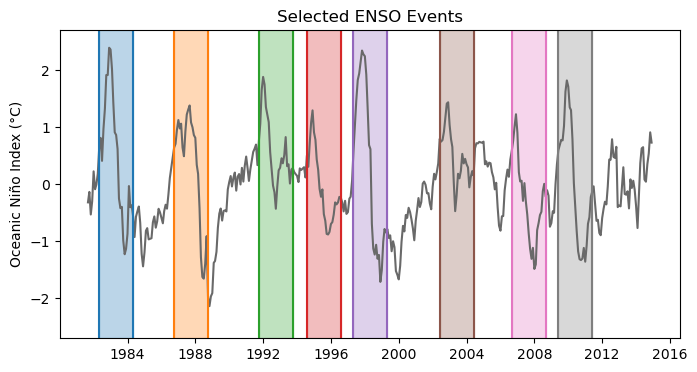

In [100]:
plt.figure(figsize=(8,4))
plt.plot(oni.time, oni.squeeze(), color='dimgrey')
plt.ylim(-2.7, 2.7)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
lines = [['05-1982', '05-1984'],
         ['10-1986', '10-1988'],
         ['10-1991', '10-1993'],
         ['08-1994', '08-1996'],
         ['05-1997', '05-1999'],
         ['06-2002', '06-2004'],
         ['09-2006', '09-2008'],
         ['06-2009', '06-2011']]

plt.title('Selected ENSO Events')
plt.ylabel('Oceanic Niño Index (°C)')

for i in range(8):
    plt.vlines(x=oni.sel(time=lines[i][0]).time, ymin=-2.8, ymax=2.8, color=colors[i])
    plt.vlines(x=oni.sel(time=lines[i][1]).time, ymin=-2.8, ymax=2.8, color=colors[i])
    plt.fill_betweenx(y=[-2.7, 2.7], x1=oni.sel(time=lines[i][0]).time, x2=oni.sel(time=lines[i][1]).time, color=colors[i], alpha=.3)

plt.savefig('ENSO_timeseries.png', bbox_inches='tight')

## Correlation Analysis
### We selected 8 El Niño events and analysed the correlation between SIE and SST anomaly:

### Arctic

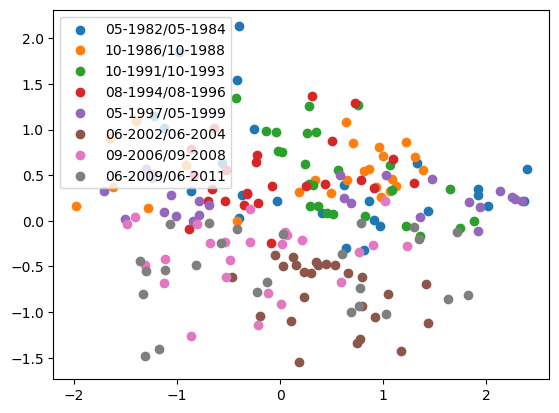

In [101]:
## scatter plot between SIE anomaly and SST anomaly

colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
elnino_events = ['05-1982/05-1984',
                 '10-1986/10-1988',
                 '10-1991/10-1993',
                 '08-1994/08-1996',
                 '05-1997/05-1999',
                 '06-2002/06-2004',
                 '09-2006/09-2008',
                 '06-2009/06-2011']
for i in range(8):
    years = elnino_events[i].split(sep='/')
    start, end = years[0], years[1]
    plt.scatter(ENSO_anom.sst.sel(time = slice(start, end)).mean(dim=['lat','lon']), SIE_art_n.sel(time = slice(start, end)), 
                color = colors[i], 
                label = elnino_events[i] 
               )
plt.legend()

In [102]:
## Calculating correlation coefficient and p-values

r_list = []
p_list = []

def get_corr(t0,t1):
    r, p = stats.pearsonr(oni.sel(time = slice(t0, t1)),SIE_art.sel(time = slice(t0, t1)))
    r_list.append(r)
    p_list.append(p)

elnino_events = ['05-1982/05-1984',
                 '10-1986/10-1988',
                 '10-1991/10-1993',
                 '08-1994/08-1996',
                 '05-1997/05-1999',
                 '06-2002/06-2004',
                 '09-2006/09-2008',
                 '06-2009/06-2011']
for event in elnino_events:
    years = event.split(sep='/')
    start, end = years[0], years[1]
    get_corr(start, end)

In [103]:
print(r_list,p_list)

[-0.5019723750541926, 0.11509092752347219, -0.6427424832177606, 0.2592283760300551, -0.06889408914875947, -0.3457407477492, 0.09606766790132873, 0.11749714964572867] [0.01056339065921258, 0.583815910728365, 0.0005303830567163321, 0.2108220536303641, 0.7434985326887643, 0.09048137447619095, 0.6478105814920551, 0.5759213851902127]


### Antarctic

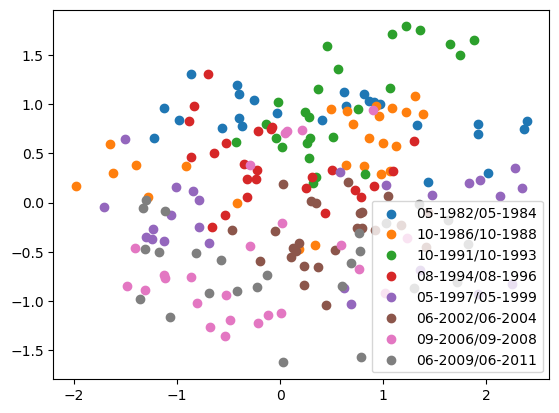

In [104]:
## scatter plot between SIE anomaly and SST anomaly

colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
elnino_events = ['05-1982/05-1984',
                 '10-1986/10-1988',
                 '10-1991/10-1993',
                 '08-1994/08-1996',
                 '05-1997/05-1999',
                 '06-2002/06-2004',
                 '09-2006/09-2008',
                 '06-2009/06-2011']
for i in range(8):
    years = elnino_events[i].split(sep='/')
    start, end = years[0], years[1]
    plt.scatter(oni.sel(time = slice(start, end)), SIE_ant.sel(time = slice(start, end)), 
                color = colors[i], 
                label = elnino_events[i] 
               )
plt.legend()

In [105]:
## Calculating correlation coefficient and p-values

r_list_ant = []
p_list_ant = []

def get_corr(t0,t1):
    r, p = stats.pearsonr(oni.sel(time = slice(t0, t1)),SIE_ant.sel(time = slice(t0, t1)))
    r_list_ant.append(r)
    p_list_ant.append(p)

elnino_events = ['05-1982/05-1984',
                 '10-1986/10-1988',
                 '10-1991/10-1993',
                 '08-1994/08-1996',
                 '05-1997/05-1999',
                 '06-2002/06-2004',
                 '09-2006/09-2008',
                 '06-2009/06-2011']
for event in elnino_events:
    years = event.split(sep='/')
    start, end = years[0], years[1]
    get_corr(start, end)

In [106]:
print(r_list_ant, p_list_ant)

[-0.40093783841737046, 0.45332189582311416, 0.6902445684088296, -0.30948319882438285, -0.06166824270824404, 0.25892481544897505, 0.376811258309578, -0.0033738000435152562] [0.04700162055857564, 0.022855557331771272, 0.00013428558112069122, 0.13221223368853832, 0.7696490532510302, 0.21137603816272119, 0.06335216016392162, 0.9872301172664374]


## Cross-Correlation Analysis

In [107]:
## Function for calculating lag and correlation coef.

def calculate_cross_correlation(ts1, ts2): 
    lags = np.arange(-len(ts1) + 1, len(ts1)) 
    cross_corr = signal.correlate(ts1 - ts1.mean(), ts2 - ts2.mean(), mode='full') / (len(ts1) * ts1.std() * ts2.std()) 
    return lags, cross_corr

In [108]:
## Function for calculating p-value

def calculate_p_value(ts1, ts2, num_surrogates=1000): # Calculate cross-correlation for the original data lags, 
    lags, original_corr = calculate_cross_correlation(ts1, ts2) # Initialize list for surrogate correlations 
    surrogate_corrs = np.zeros((num_surrogates, len(lags))) # Generate surrogate data and compute cross-correlation 
    for i in range(num_surrogates): 
        shuffled_ts2 = np.random.permutation(ts2) 
        _, surrogate_corr = calculate_cross_correlation(ts1, shuffled_ts2) 
        surrogate_corrs[i, :] = surrogate_corr 
        # Compute p-values by comparing the observed correlation to surrogate correlations 
        p_values = np.mean(np.abs(surrogate_corrs) >= np.abs(original_corr), axis=0) 
    return lags, original_corr, surrogate_corrs, p_values

### Arctic

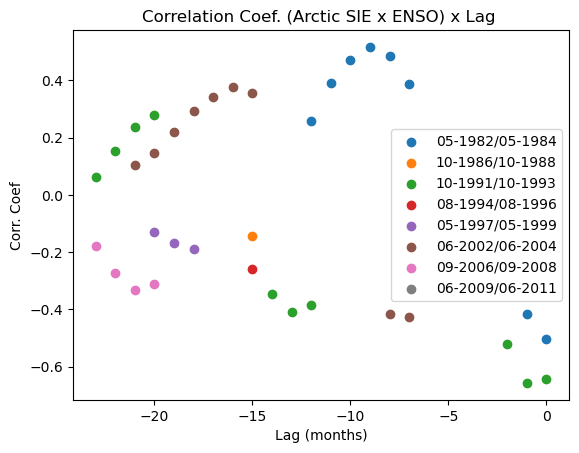

In [109]:
## scatter plot between significant correlation coef. values and lag

colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
elnino_events = ['05-1982/05-1984',
                  '10-1986/10-1988',
                  '10-1991/10-1993',
                  '08-1994/08-1996',
                  '05-1997/05-1999',
                  '06-2002/06-2004',
                  '09-2006/09-2008',
                  '06-2009/06-2011']

for i in range(8):
    years = elnino_events[i].split(sep='/')
    start, end = years[0], years[1]
    lags, original_corr, surrogate_corrs, p_values = calculate_p_value(oni.sel(time = slice(start,end)).values,
                                                                       SIE_art.sel(time = slice(start,end)).values)
    dict = {'lags':lags,'original_corr':original_corr,'p_values':p_values}
    df = pd.DataFrame(data=dict)
    df['r2']= (df.original_corr)**2
    df_filt = df.where((df.p_values <= 0.05)&(df.lags<=0)).dropna()

    plt.scatter(df_filt.lags,df_filt.original_corr, 
                color = colors[i], 
                label = elnino_events[i]) 
plt.legend()
plt.title('Correlation Coef. (Arctic SIE x ENSO) x Lag ')
plt.xlabel('Lag (months)')
plt.ylabel('Corr. Coef')
plt.savefig('Corr_Lag_arctic.png',bbox_inches='tight' )

### Antarctic

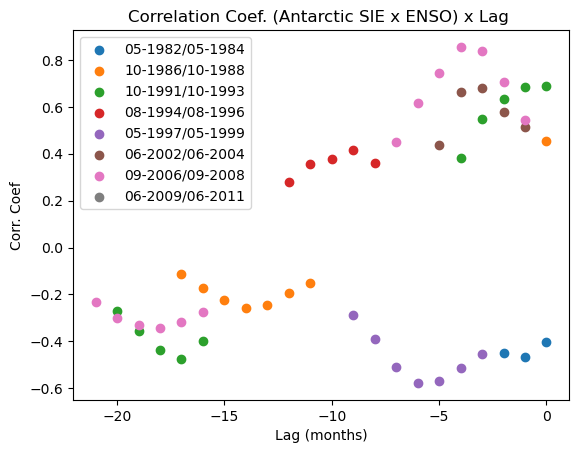

In [110]:
## scatter plot between significant correlation coef. values and lag

colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
elnino_events = ['05-1982/05-1984',
                  '10-1986/10-1988',
                  '10-1991/10-1993',
                  '08-1994/08-1996',
                  '05-1997/05-1999',
                  '06-2002/06-2004',
                  '09-2006/09-2008',
                  '06-2009/06-2011'
 ]

for i in range(8):
    years = elnino_events[i].split(sep='/')
    start, end = years[0], years[1]
    lags, original_corr, surrogate_corrs, p_values = calculate_p_value(oni.sel(time = slice(start,end)).values,
                                                                       SIE_ant.sel(time = slice(start,end)).values)
    dict = {'lags':lags,'original_corr':original_corr,'p_values':p_values}
    df = pd.DataFrame(data=dict)
    df['r2']= (df.original_corr)**2
    df_filt = df.where((df.p_values <= 0.05)&(df.lags<=0)).dropna()

    plt.scatter(df_filt.lags,df_filt.original_corr, 
                color = colors[i], 
                label = elnino_events[i]) 
plt.legend()
plt.title('Correlation Coef. (Antarctic SIE x ENSO) x Lag ')
plt.xlabel('Lag (months)')
plt.ylabel('Corr. Coef')
plt.savefig('Corr_Lag_antarctic.png',bbox_inches='tight' )